**IMPORTING LIBRARIES**

In [21]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.model_selection import train_test_split

**CREATING DATAFRAME**

In [22]:
image_path = []
label = []

for class_name in os.listdir('data'):
    for file in os.listdir('data/' + class_name):
        label.append(0) if class_name == 'Cat' else label.append(1)
        image_path.append(os.path.join('data', class_name, file))

print(image_path[:5], label[:5])

['data/Dog/6375.jpg', 'data/Dog/12075.jpg', 'data/Dog/10144.jpg', 'data/Dog/795.jpg', 'data/Dog/4957.jpg'] [1, 1, 1, 1, 1]


In [23]:
df = pd.DataFrame()
df['IMAGE'] = image_path
df['LABEL'] = label

# shuffle the rows of a DataFrame and reset the index
df = df.sample(frac=1).reset_index(drop=True)

print(df.shape)
df.head()

(25002, 2)


,IMAGE,LABEL
0,data/Dog/4290.jpg,1
1,data/Dog/4467.jpg,1
2,data/Cat/9008.jpg,0
3,data/Cat/4897.jpg,0
4,data/Dog/4067.jpg,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25002 entries, 0 to 25001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   IMAGE   25002 non-null  object
 1   LABEL   25002 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


**REMOVING CORRUPTED IMAGE**

In [25]:
corrupt_images = []
for image in df['IMAGE']:
    try:
        img = PIL.Image.open(image)
    except:
        corrupt_images.append(image)

corrupt_images

['data/Cat/666.jpg',
 'data/Cat/Thumbs.db',
 'data/Dog/Thumbs.db',
 'data/Dog/11702.jpg']

In [26]:
# Drop rows that contain any of the corrupt_images
df = df[~df.isin(corrupt_images).any(axis = 1)]
print(df.shape)  # before --> (25002, 2)

(24998, 2)


**EXPLORATORY DATA ANALYSIS**

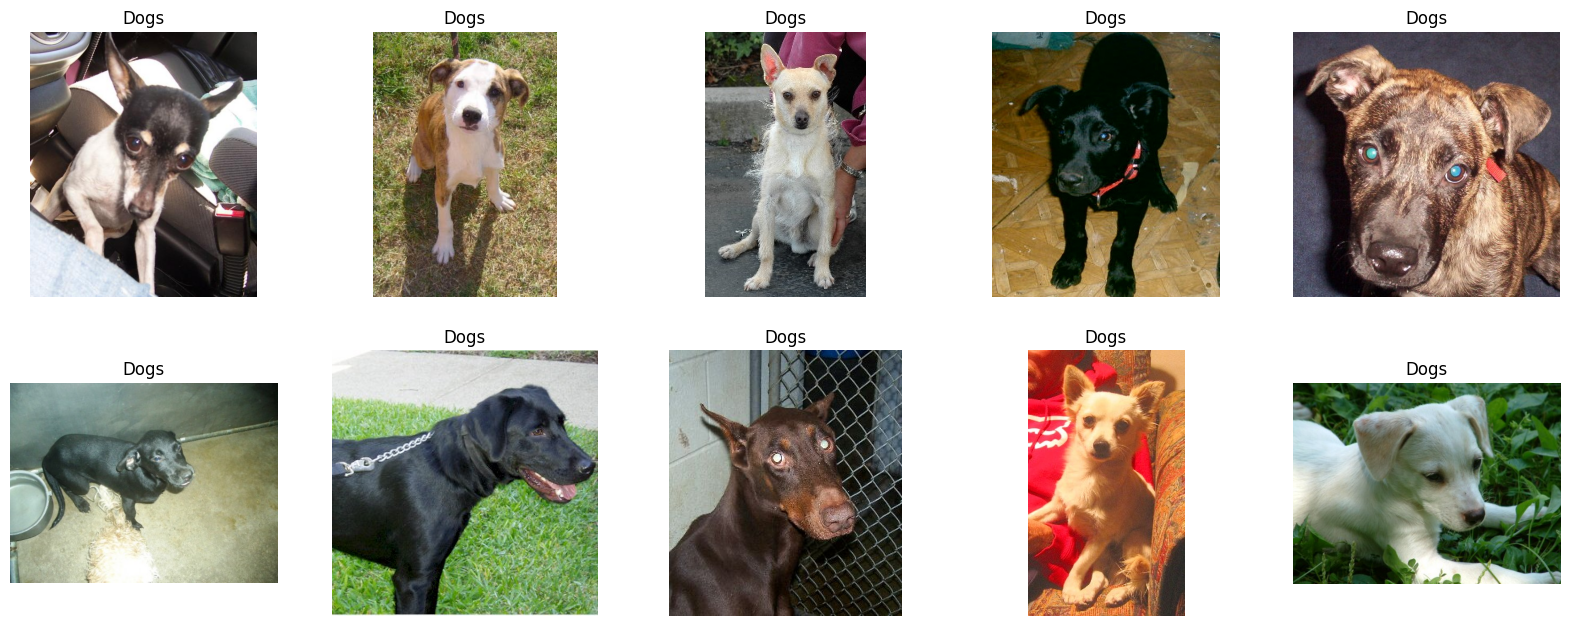

In [27]:
plt.figure(figsize = (20, 20))

temp = df[df['LABEL'] == 1]['IMAGE']
num = random.randint(0, len(temp))
files = temp[num : num + 10]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

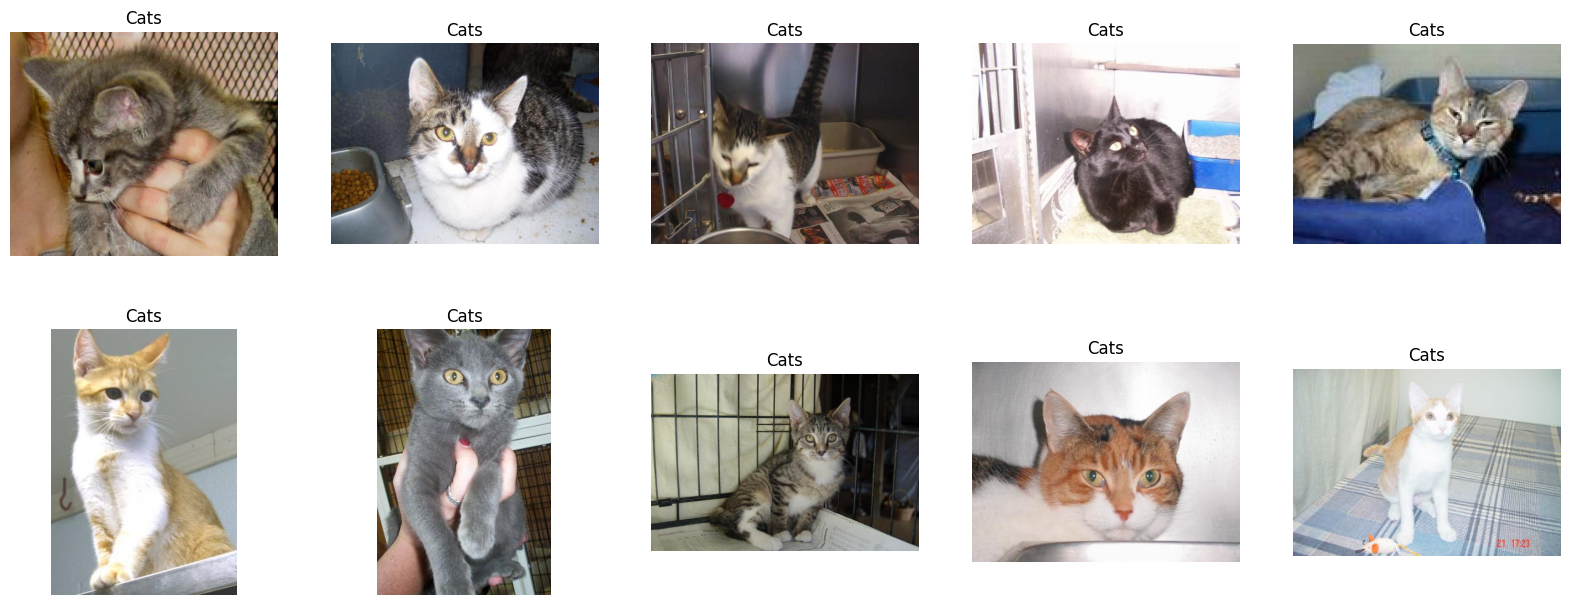

In [28]:
plt.figure(figsize = (20, 20))

temp = df[df['LABEL'] == 0]['IMAGE']
num = random.randint(0, len(temp))
files = temp[num : num + 10]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

**DATAGENERATORS FOR IMAGES**

In [29]:
df['LABEL'] = df['LABEL'].astype('str')
df.head()

,IMAGE,LABEL
0,data/Dog/4290.jpg,1
1,data/Dog/4467.jpg,1
2,data/Cat/9008.jpg,0
3,data/Cat/4897.jpg,0
4,data/Dog/4067.jpg,1


In [30]:
# split input
train, test = train_test_split(df, test_size=0.2, random_state=42)
print(train.shape, test.shape)

(19998, 2) (5000, 2)


In [31]:
# Creating an ImageDataGenerator instance for the training data with various augmentations
train_generator = ImageDataGenerator(
    rescale = 1./255, # normalization
    rotation_range = 40, # augmentation of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# Creating an ImageDataGenerator instance for the validation data with only normalization
val_generator = ImageDataGenerator(rescale = 1./255)


# Creating a training data iterator using flow_from_dataframe method
train_iterator = train_generator.flow_from_dataframe(
    dataframe = train,  # DataFrame containing the training data
    x_col = 'IMAGE',
    y_col = 'LABEL',
    target_size = (128,128),
    batch_size = 512,
    class_mode = 'binary'
)

# Creating a validation data iterator using flow_from_dataframe method
val_iterator = val_generator.flow_from_dataframe(
    dataframe = test, # DataFrame containing the testing data
    x_col = 'IMAGE',
    y_col = 'LABEL',
    target_size = (128,128),
    batch_size = 512,
    class_mode = 'binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


**MODEL**

In [32]:
model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 64)       

In [33]:
model_training_history = model.fit(train_iterator, epochs = 10, validation_data = val_iterator)

Epoch 1/10
40/40 [==============================] - 130s 3s/step - loss: 0.6792 - accuracy: 0.5831 - val_loss: 0.5981 - val_accuracy: 0.6864
Epoch 2/10
40/40 [==============================] - 111s 3s/step - loss: 0.5866 - accuracy: 0.6873 - val_loss: 0.5646 - val_accuracy: 0.7094
Epoch 3/10
40/40 [==============================] - 112s 3s/step - loss: 0.5447 - accuracy: 0.7239 - val_loss: 0.5738 - val_accuracy: 0.6946
Epoch 4/10
40/40 [==============================] - 114s 3s/step - loss: 0.5189 - accuracy: 0.7403 - val_loss: 0.4817 - val_accuracy: 0.7666
Epoch 5/10
40/40 [==============================] - 112s 3s/step - loss: 0.5032 - accuracy: 0.7549 - val_loss: 0.4693 - val_accuracy: 0.7774
Epoch 6/10
40/40 [==============================] - 114s 3s/step - loss: 0.4773 - accuracy: 0.7745 - val_loss: 0.4504 - val_accuracy: 0.7882
Epoch 7/10
40/40 [==============================] - 111s 3s/step - loss: 0.4910 - accuracy: 0.7581 - val_loss: 0.4424 - val_accuracy: 0.7928
Epoch 8/10
40

**VISUALIZATION OF RESULT**

In [34]:
# function will plot the metrics passed to it in a graph
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))
    plt.legend()

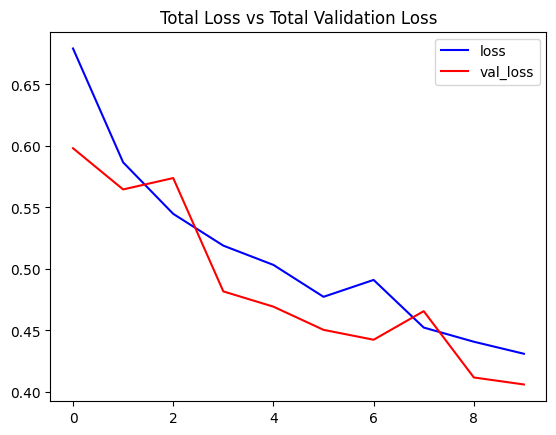

In [35]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

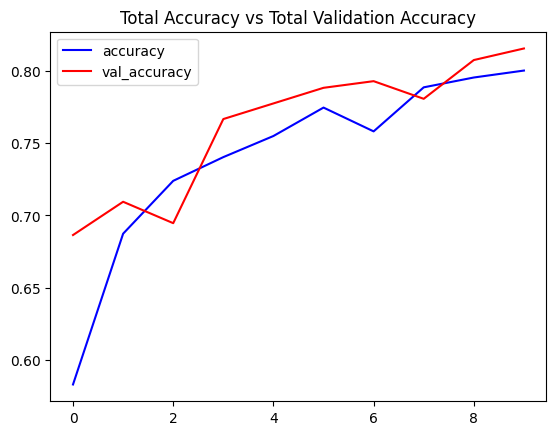

In [36]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**TESTING ON REAL IMAGE**

In [37]:
image_path = "dog.jpg" # path of the image

img = load_img(image_path, target_size=(128, 128)) # loading image

img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction

# prediction
pred = model.predict(img)
if pred[0] > 0.5:
    print('Dog')
else:
    print('Cat')

1/1 [==============================] - 0s 68ms/step
Dog


In [38]:
image_path = "cat.jpg" # path of the image

img = load_img(image_path, target_size=(128, 128)) # loading image

img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction

# prediction
pred = model.predict(img)
if pred[0] > 0.5:
    print('Dog')
else:
    print('Cat')

1/1 [==============================] - 0s 18ms/step
Cat
